<a href="https://colab.research.google.com/github/NarenChittem/GlobalStudiesFinal/blob/main/Copy_of_08_sentiment_analysis_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with BERT

> TL;DR In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

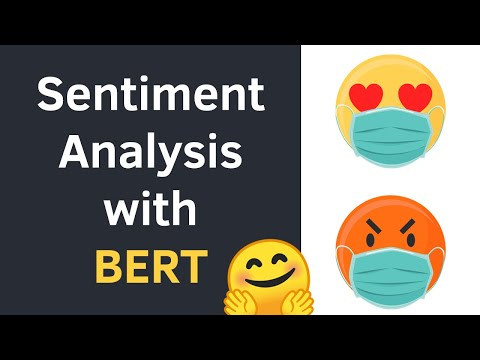

In [56]:
#@title Watch the video tutorial

from IPython.display import YouTubeVideo
YouTubeVideo('8N-nM3QW7O0', width=720, height=420)

In [57]:
!nvidia-smi

!pip install -q -U watermark

!pip install -qq transformers

!pip install pyspellchecker

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Mon May 15 17:29:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    42W / 300W |   6804MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [58]:
!pip install -qq transformers

In [59]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.0+cu118
transformers: 4.29.1



## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [60]:
import os
import pandas as pd

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File path of the CSV files
csv_folder = '/content/drive/MyDrive/archive/'

# Read data from the uploaded dataset files
processed_positive_df = pd.read_csv(os.path.join(csv_folder, 'processedPositive.csv'), header=None)
processed_negative_df = pd.read_csv(os.path.join(csv_folder, 'processedNegative.csv'), header=None)
processed_neutral_df = pd.read_csv(os.path.join(csv_folder, 'processedNeutral.csv'), header=None)

# Reshape the dataframes
processed_positive_df = processed_positive_df.transpose().dropna()
processed_negative_df = processed_negative_df.transpose().dropna()
processed_neutral_df = processed_neutral_df.transpose().dropna()

# Add labels to the dataframes
processed_positive_df['labels'] = 2
processed_negative_df['labels'] = 1
processed_neutral_df['labels'] = 0

# Concatenate the dataframes
df = pd.concat([processed_positive_df, processed_negative_df, processed_neutral_df], ignore_index=True)
df.columns = ['tweet_text', 'labels']  # Assign column names


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
df.duplicated().sum()
df = df[df.duplicated() == False]


In [62]:
df.head()

,tweet_text,labels
0,An inspiration in all aspects: Fashion,2
1,fitness,2
2,beauty and personality. :)KISSES TheFashionIcon,2
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,2
4,Beautiful album from the greatest unsung guit...,2


In [63]:
label_counts = df['labels'].value_counts()
print(label_counts)

0    1478
2    1001
1     981
Name: labels, dtype: int64


## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [64]:
import torch
from transformers import BertModel, BertTokenizer
from spellchecker import SpellChecker

# Set the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Create an instance of the BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Function to correct spelling errors
def correct_spelling(text):
    spell = SpellChecker()
    words = text.split()
    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        corrected_words.append(corrected_word)
    return ' '.join(corrected_words)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [65]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [66]:
from torch.utils.data import Dataset

class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True, 
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [67]:
from sklearn.model_selection import train_test_split
import random

RANDOM_SEED = random.randint(1, 1000)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=RANDOM_SEED)

In [68]:
df_train.shape, df_val.shape, df_test.shape

((2422, 2), (726, 2), (312, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [69]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(
      tweets=df.tweet_text.to_numpy(),
      labels=df.labels.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )


In [70]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


Let's have a look at an example batch from our training data loader:

In [71]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'labels'])

In [72]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [73]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We can use all of this knowledge to create a classifier that uses the BERT model:

In [74]:
import torch.nn as nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)


In [75]:
import torch
import torch.nn as nn
from transformers import BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['positive', 'negative', 'neutral']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [77]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4395, 0.3369, 0.2236],
        [0.6481, 0.2340, 0.1179],
        [0.4045, 0.3627, 0.2328],
        [0.3449, 0.4173, 0.2378],
        [0.4910, 0.3618, 0.1472],
        [0.3127, 0.5278, 0.1595],
        [0.5287, 0.3176, 0.1537],
        [0.3948, 0.4558, 0.1494],
        [0.3367, 0.4838, 0.1796],
        [0.5132, 0.3363, 0.1505],
        [0.3444, 0.5169, 0.1387],
        [0.5618, 0.2765, 0.1617],
        [0.4236, 0.3751, 0.2013],
        [0.4183, 0.4395, 0.1422],
        [0.3004, 0.5088, 0.1908],
        [0.4042, 0.3866, 0.2092]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [78]:
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [79]:
import torch
import numpy as np
import torch.nn as nn

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets.flatten()) # Updated: Flatten targets - reverse if it is not working

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [80]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [81]:
from collections import defaultdict
import torch
import numpy as np
from tqdm import tqdm
import time

start_time = time.time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.4894794424946763 accuracy 0.8038810900082576
Val   loss 0.24298213126704746 accuracy 0.9242424242424243

Epoch 2/10
----------
Train loss 0.1473212612572273 accuracy 0.9438480594549958
Val   loss 0.28184379796679737 accuracy 0.9242424242424243

Epoch 3/10
----------
Train loss 0.074202878668745 accuracy 0.9781172584640793
Val   loss 0.35266355204942595 accuracy 0.928374655647383

Epoch 4/10
----------
Train loss 0.03260515333481875 accuracy 0.9880264244426094
Val   loss 0.3839783014801746 accuracy 0.9338842975206612

Epoch 5/10
----------
Train loss 0.008869944297514035 accuracy 0.9971098265895953
Val   loss 0.43264339481949876 accuracy 0.9325068870523416

Epoch 6/10
----------
Train loss 0.004220379259526166 accuracy 0.9983484723369116
Val   loss 0.4526884260434915 accuracy 0.9338842975206612

Epoch 7/10
----------
Train loss 0.0004498122626070031 accuracy 1.0
Val   loss 0.4789578605053501 accuracy 0.9338842975206612

Epoch 8/10
----------
Train loss

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

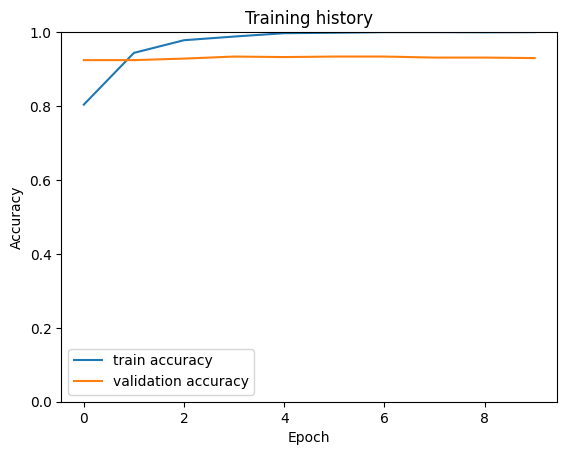

In [82]:
import matplotlib.pyplot as plt
import numpy as np

train_acc = [acc.cpu().numpy() for acc in history['train_acc']]
val_acc = [acc.cpu().numpy() for acc in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

plt.show()


The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [83]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [84]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.923076923076923

In [85]:
import os

# Define the file path for saving the model
save_path = "./mbb.pth"
torch.save(model.state_dict(), save_path)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

load_path = "./mbb.pth"
model.load_state_dict(torch.load(load_path, map_location=device))

model.eval()



test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

test_data = next(iter(test_data_loader))
test_data = {key: val.to(device) for key, val in test_data.items() if key != 'tweet_text'}


test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test loss: 0.5428004210254584, Test accuracy: 0.923076923076923


The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [95]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  twitter_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      twitter_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return twitter_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [96]:
y_twitter_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.96      0.97      0.97       142
    negative       0.93      0.89      0.91        83
     neutral       0.86      0.87      0.87        87

    accuracy                           0.92       312
   macro avg       0.92      0.91      0.91       312
weighted avg       0.92      0.92      0.92       312



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

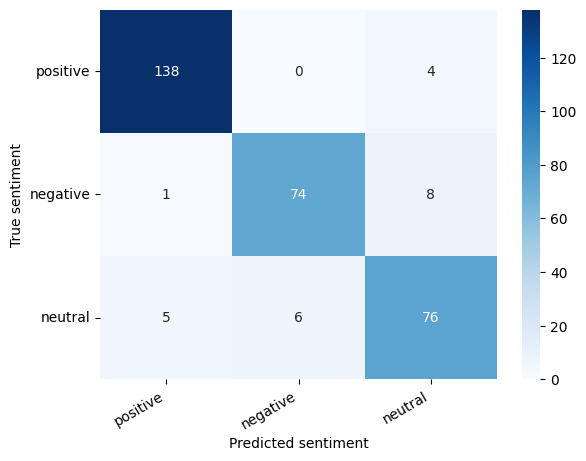

In [98]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [99]:
idx = 2

twitter_text = y_twitter_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [103]:
import textwrap

print("\n".join(textwrap.wrap(twitter_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Oil prices hit three-month low as U.S. rig count climbs

True sentiment: positive


Now we can look at the confidence of each sentiment of our model:

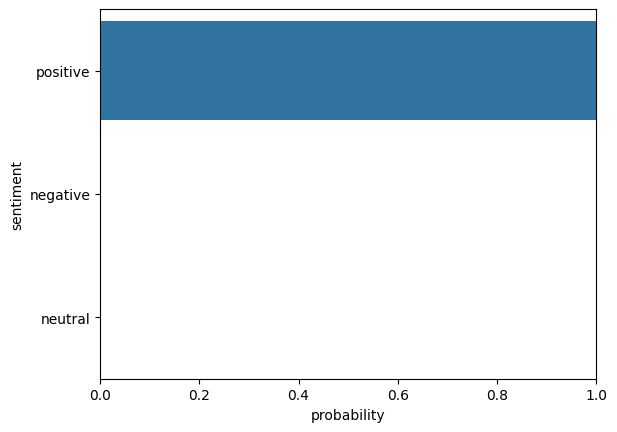

In [104]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);